In [1]:
'''
experiment - semi-converging EM
'''
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from matplotlib import pyplot as plt
import seaborn as sns
import agent
import dungeon as fl
import utils

# pretify
sns.set_style('whitegrid')

In [2]:
'''
data structures to store the results
'''
log = pd.DataFrame(columns=['algorithm',
                           'average-reward/time-step'])

In [3]:
'''
game details and parameters
'''
# make the game to get details
game = fl.make_game()
obs = game.its_showtime()

# parameters
num_experiments = 100
world_param = fl.get_params()
num_states = world_param['num_states']
num_actions = world_param['num_actions']
len_episodes = 100
discount = 0.9
# reward function
reward = 10 * np.ones((num_states, num_actions))
# update rewards (state, action) for movement into goal and traps
reward[0, 3] = 0
reward[1, 3] = 0
reward[2, 3] = 20
# start distribution - uniform (but there are 2 confusion states)
start_dist = np.ones(num_states)
start_dist[3] += 1
start_dist /= np.sum(start_dist)

# transition distribution (just alpha counts)
alpha = np.zeros((num_states, num_states, num_actions))
# go through all states
# going north is useless
alpha[0, 0, 2] = 1
alpha[1, 1, 2] = 1
alpha[2, 2, 2] = 1
alpha[3, 3, 2] = 1
# going south is useless if there is a wall
alpha[3, 3, 3] = 1
# going south has uniform distribution if there is no wall
alpha[:, 0, 3] = 1
alpha[:, 1, 3] = 1
alpha[:, 2, 3] = 1
# going left and right is useless, if next to a wall
alpha[1, 1, 1] = 1
alpha[0, 0, 0] = 1
# from middle, going both left/right takes to confusion
alpha[3, 2, 0] = 1
alpha[3, 2, 1] = 1
# from right end, going left takes to confusion
alpha[3, 1, 0] = 1
# from left end, going right takes to confusion
alpha[3, 0, 1] = 1
# from confusion it is confusing
alpha[2, 3, 0] = 1
alpha[0, 3, 0] = 1
alpha[2, 3, 1] = 1
alpha[1, 3, 1] = 1

In [4]:
'''
Using EM
'''
# for every experiment
for _ in tqdm(range(num_experiments)):
    # reset total reward per episode count
    total_reward = 0
    # create agent
    bond = agent.MLEM(num_actions,
                      num_states,
                      discount,
                      len_episodes)
    # set transition distribution
    bond.alpha = np.copy(alpha)
    bond.update_theta()
    # set reward details
    bond.reward = np.copy(reward)
    # set start distribution
    bond.start_dist = np.copy(start_dist)

    # learn policy
    bond.learn(niter=250)
    # make game for evaluation
    game = fl.make_game()
    obs = game.its_showtime()
    for _ in range(len_episodes):
        action = bond.play(utils.get_dungeon_state(obs))
        obs = game.play(action)
        if not obs[1] is None:
            total_reward += obs[1]        
    # add average reward to log
    log=log.append(pd.DataFrame(
        {'algorithm': "MDP-EM",
         'average-reward/time-step': total_reward/len_episodes},
        index=[log.size+1]))
    # quit game
    game.play(5)

# print final policy
print("States:\t\t left, right, middle, confuse")
print("action left\t", np.round(bond.policy[0], 2))
print("action right\t", np.round(bond.policy[1], 2))
print("action up\t", np.round(bond.policy[2], 2))
print("action down\t", np.round(bond.policy[3], 2))


States:		 left, right, middle, confuse
action left	 [0.   0.99 0.   0.17]
action right	 [0.99 0.01 0.   0.82]
action up	 [0.01 0.01 0.   0.  ]
action down	 [0.   0.   1.   0.01]


In [5]:
'''
Using Policy Iteration
'''
# for every experiment
for _ in tqdm(range(num_experiments)):
    # reset total reward per episode count
    total_reward = 0
    # create agent
    bond = agent.PoliQ(num_actions,
                      num_states,
                      discount,
                      len_episodes)
    # set transition distribution
    bond.alpha = np.copy(alpha)
    bond.update_theta()
    # set reward details
    bond.reward = np.copy(reward)
    # set start distribution
    bond.start_dist = np.copy(start_dist)
    
    # learn policy
    bond.learn(niter=250)
    # make game for evaluation
    game = fl.make_game()
    obs = game.its_showtime()
    for _ in range(len_episodes):
        action = bond.play(utils.get_dungeon_state(obs))
        obs = game.play(action)
        if not obs[1] is None:
            total_reward += obs[1]        
    # add average reward to log
    log=log.append(pd.DataFrame(
        {'algorithm': "MDP-PI",
         'average-reward/time-step': total_reward/len_episodes},
        index=[log.size+1]))
    # quit game
    game.play(5)
    
# print final policy
print("Policy:\t\t action (0=left, 1=right, 2=up, 3=down)")
print("state left\t", np.round(bond.policy[0], 2))
print("state right\t", np.round(bond.policy[1], 2))
print("state middle\t", np.round(bond.policy[2], 2))
print("state conf\t", np.round(bond.policy[3], 2))


Policy:		 action (0=left, 1=right, 2=up, 3=down)
state left	 1
state right	 0
state middle	 3
state conf	 0


In [6]:
'''
save the reward values
'''
log.to_pickle("exp_dun.pkl")

/usr/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


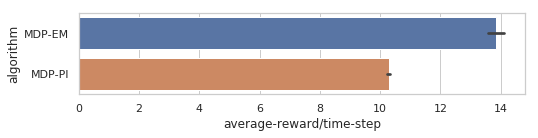

In [14]:
'''
code for plotting a good graph
'''
sns.set(rc={'figure.figsize':(8,1.5)})
sns.set_style('whitegrid')
sns.barplot(y="algorithm",
              x="average-reward/time-step",
              data=log,
              ci=90)
plt.savefig('exp_dun_result.png', dpi=600, bbox_inches="tight")